In [1]:
library(plyr)
library(data.table)
library(stringr)
library(ggplot2)

In [2]:
all_res <- NULL
for (file in list.files("/illumina/scratch/deep_learning/asalcedo/scATAC/LDSC/brca_ss_vs_all_peaks_v2/", full.names=TRUE)){
    res_df <- fread(file)
    if(!grepl(".results", file) | grepl("price", file)){
        next
    }
    res_df <- res_df[,1:7]
    base_name <- gsub("/.*/","", file)
    varset <- str_split(base_name, "_")[[1]][1]
    tissue <- str_split(base_name, "_")[[1]][2]
    peakset <- str_split(base_name, "_peaks_")[[1]][2]
    peakset <- gsub(".results","", peakset)

    res_df$varset <- varset
    res_df$tissue <- tissue
    res_df$peakset <- peakset
    res_df$file <- base_name
    all_res <- rbind(all_res, tail(res_df,1))
    
}

Warning message in fread(file):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(file):
“Stopped early on line 13. Expected 3 fields but found 2. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<--overlap-annot  \>>”
Warning message in fread(file):
“Detected 2 column names but the data has 3 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread(file):
“Stopped early on line 13. Expected 3 fields but found 2. Consider fill=TRUE and comment.char=. First disc

In [4]:
plot_res_df <- all_res[tissue %in% c('BREAST','BRCA','GBM','BRAIN'),]
plot_res_df[tissue == "BRCA", tissue:='BREAST']
plot_res_df[tissue == "GBM", tissue:='BRAIN']

In [5]:
plot_res_df[varset=="PCP", varset:="UKBB"]
plot_res_df[varset=="bcac", varset:="BCAC"]
plot_res_df[varset=="finngen", varset:="Finngen"]

In [6]:
plot_res_df[peakset == "tumorNN", peakset:="Nearest neighbor normal peaks"]
plot_res_df[peakset == "NNnormal_tumor_overlap", peakset:="Tumor peaks overlapping normal peaks"]
plot_res_df[peakset == "NNnormal_nontumor", peakset:="Normal peaks not overlapping tumor peaks"]
plot_res_df[peakset == "tumor_non_normal", peakset:="Tumor peaks not overlapping normal peaks"]
plot_res_df[peakset == "tumor", peakset:="All tumor peaks"]
plot_res_df[peakset == "normal", peakset:="All normal peaks"]

In [7]:
plot_res_df[Enrichment < 0, Enrichment:=0] #see in LDSC FAQ

In [11]:
plot_res_df[,Enrichment_p_adj:=p.adjust(Enrichment_p, method="fdr")]

In [13]:
plot_res_df[,Category:=NULL]
plot_res_df[,file:=NULL]

In [19]:
out_res_df <- cbind(plot_res_df[,7:9], plot_res_df[,1:6], plot_res_df[,10])

In [21]:
colnames(out_res_df)[1] <- "variants"

In [22]:
write.table(out_res_df, file="/illumina/scratch/deep_learning/asalcedo/scATAC/tables/ldsc_variants.txt", quote=FALSE, row.names = FALSE, sep="\t")

In [19]:
mean_enrich <- plot_res_df[,mean(Enrichment), by=peakset][order(V1),]

In [21]:
plot_res_df$peakset2 <- factor(plot_res_df$peakset, levels=mean_enrich[[1]])

In [24]:
plot_res_df[,idx:=as.numeric(factor(paste0(varset,tissue)))]

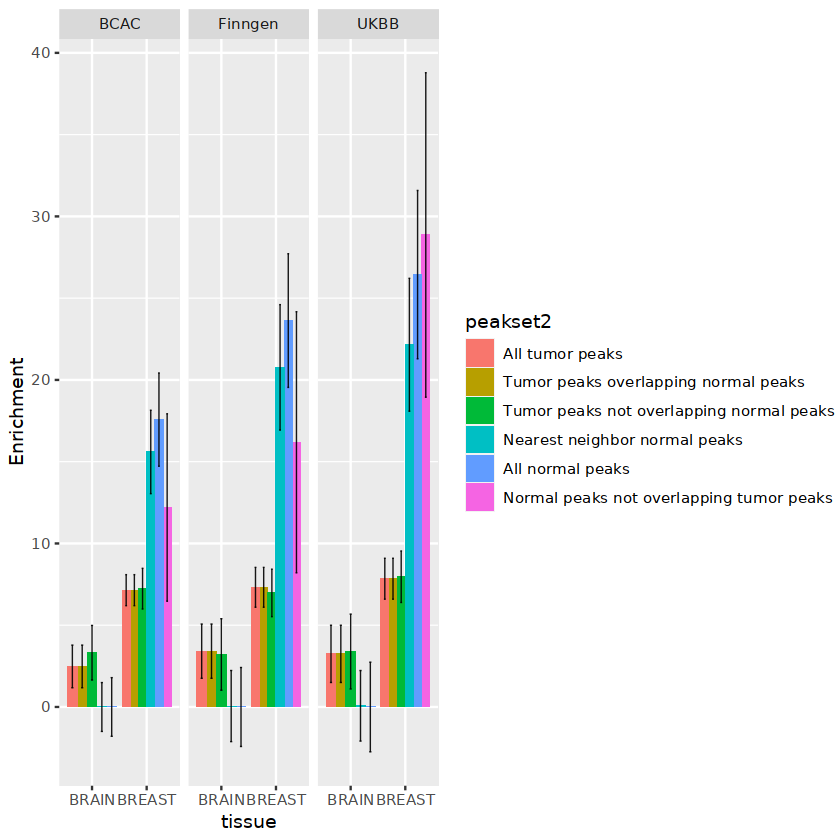

In [25]:
ggplot(plot_res_df, aes(x=tissue, y=Enrichment, fill=peakset2)) + geom_col(position="dodge") + geom_errorbar( aes( ymin=Enrichment-Enrichment_std_error, ymax=Enrichment + Enrichment_std_error),position=position_dodge(.9), width=0.2, colour="black", alpha=0.9, size=.3) + facet_grid(cols=vars(varset))